In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets

from stellarpunk import util

In [2]:
df_base = pd.json_normalize(list(json.loads(line) for line in open("/tmp/stellarpunk_test.history", "r")))

In [3]:
df_base["eid"].unique()

array(['dfc0444e-96bf-46ed-bc42-deb5297fcaf4'], dtype=object)

In [4]:
target_eid = df_base["eid"].unique()[0]
df_base = df_base[df_base["eid"] == target_eid].reset_index()
df_base["eid"].unique()

array(['dfc0444e-96bf-46ed-bc42-deb5297fcaf4'], dtype=object)

In [5]:
df_base

,index,eid,ts,loc,a,v,av,o.o,o.ct,o.ct_loc,o.ct_ts,o.ct_dv,o.cac,o.cbdr,o.nnd,o.t_loc,o.t_v,o.cs,o
0,0,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.500000,"[-320.65406213909097, 17359.592585709543]",1.546130,"[19.682913561619074, -497.22700562657604]",0.292740,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",7.500000,"[19.416854374700787, 0.3586543404443903]",False,False,7359.621568,"[0, 0]","[32.31924380756785, -1749.7015363997675]",False,NaN
1,1,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.516667,"[-320.32601357973067, 17351.3054689491]",1.551009,"[19.680685644144337, -493.06033955554335]",0.276073,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",7.516667,"[18.88664008804558, 0.34867014128391055]",False,False,7351.333569,"[0, 0]","[32.30160540066043, -1749.701862114955]",False,NaN
2,2,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.533333,"[-319.99800215232824, 17343.087796623175]",1.555610,"[19.673980215582862, -488.89367828441283]",0.259406,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",7.533333,"[18.36621684512075, 0.33887579688545433]",False,False,7343.115028,"[0, 0]","[32.28382464625276, -1749.7021902787371]",False,NaN
3,3,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.550000,"[-319.6701024820685, 17334.939568651767]",1.559934,"[19.662842374221942, -484.727026503954]",0.242740,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",7.550000,"[17.855500535579477, 0.32926966162601135]",False,False,7334.965943,"[0, 0]","[32.265909085257746, -1749.7025207477132]",False,NaN
4,4,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.566667,"[-319.34238844249813, 17326.860784876702]",1.563979,"[19.647317292330918, -480.56038876076786]",0.226073,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",7.566667,"[17.354406501806707, 0.3198500692708376]",False,False,7326.886316,"[0, 0]","[32.24786620036005, -1749.7028533798314]",False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,3595,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,67.416667,"[111.18514859657007, -586.3195038056004]",-4.699605,"[0.1994246627655496, -14.924415686629745]",0.017486,stellarpunk.orders.GoToLocation,NaN,NaN,NaN,NaN,NaN,NaN,1638.744274,"[0, 0]","[0.0, 0.0]",True,NaN
3596,3596,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,67.433333,"[111.1884723409495, -586.5682440670442]",-4.699313,"[0.14375334270401346, -10.758120952068385]",0.033979,stellarpunk.orders.GoToLocation,NaN,NaN,NaN,NaN,NaN,NaN,1638.985892,"[0, 0]","[0.0, 0.0]",True,NaN
3597,3597,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,67.450000,"[111.19086822999456, -586.7475460829121]",-4.698747,"[0.08808202264247735, -6.591826217507025]",0.017312,stellarpunk.orders.GoToLocation,NaN,NaN,NaN,NaN,NaN,NaN,1639.160061,"[0, 0]","[0.0, 0.0]",True,NaN
3598,3598,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,67.466667,"[111.19233626370527, -586.8574098532039]",-4.698458,"[0.032410702580940295, -2.425531482945665]",0.000646,stellarpunk.orders.GoToLocation,NaN,NaN,NaN,NaN,NaN,NaN,1639.266780,"[0, 0]","[0.0, 0.0]",True,NaN


In [6]:
loc = pd.DataFrame(np.vstack(df_base["loc"]), columns=["loc.x", "loc.y"])
v = pd.DataFrame(np.vstack(df_base["v"]), columns=["v.x", "v.y"])
#TODO: handle missing columns
o_tloc = pd.DataFrame(np.vstack(df_base["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_loc.x", "o.t_loc.y"])
o_tv = pd.DataFrame(np.vstack(df_base["o.t_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_v.x", "o.t_v.y"])
if "o.ct" in df_base:
    o_ctloc = pd.DataFrame(np.vstack(df_base["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_loc.x", "o.ct_loc.y"])
    o_ctdv = pd.DataFrame(np.vstack(df_base["o.ct_dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_dv.x", "o.ct_dv.y"])
else:
    empty_array = np.empty(len(df_base))
    empty_array[:] = np.nan
    o_ctloc = pd.DataFrame({"o.ct_loc": empty_array, "o.ct_loc.x": empty_array, "o.ct_loc.y": empty_array})
    o_ctdv = pd.DataFrame({"o.ct_dv": empty_array, "o.ct_dv.x": empty_array, "o.ct_dv.y": empty_array})
angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["a"])), axis=1)), columns=["angle.x", "angle.y"])
df = pd.concat([df_base, loc, v, o_ctloc, o_ctdv, o_tloc, o_tv, angle], axis=1)

In [7]:
df["speed"] = np.linalg.norm(df[["v.x", "v.y"]], axis=1)
df["o_ct_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_speed"] = np.linalg.norm(df[["o.t_v.x", "o.t_v.y"]], axis=1)

In [8]:
df

,index,eid,ts,loc,a,v,av,o.o,o.ct,o.ct_loc,...,o.t_loc.x,o.t_loc.y,o.t_v.x,o.t_v.y,angle.x,angle.y,speed,o_ct_dist,o_t_dist,o_t_speed
0,0,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.500000,"[-320.65406213909097, 17359.592585709543]",1.546130,"[19.682913561619074, -497.22700562657604]",0.292740,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",...,0.0,0.0,32.319244,-1749.701536,2.466388,99.969580,4.976164e+02,7359.621568,17362.553780,1750.0
1,1,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.516667,"[-320.32601357973067, 17351.3054689491]",1.551009,"[19.680685644144337, -493.06033955554335]",0.276073,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",...,0.0,0.0,32.301605,-1749.701862,1.978610,99.980424,4.934530e+02,7351.333569,17354.262019,1750.0
2,2,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.533333,"[-319.99800215232824, 17343.087796623175]",1.555610,"[19.673980215582862, -488.89367828441283]",0.259406,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",...,0.0,0.0,32.283825,-1749.702190,1.518559,99.988469,4.892894e+02,7343.115028,17346.039693,1750.0
3,3,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.550000,"[-319.6701024820685, 17334.939568651767]",1.559934,"[19.662842374221942, -484.727026503954]",0.242740,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",...,0.0,0.0,32.265909,-1749.702521,1.086252,99.994100,4.851257e+02,7334.965943,17337.886804,1750.0
4,4,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.566667,"[-319.34238844249813, 17326.860784876702]",1.563979,"[19.647317292330918, -480.56038876076786]",0.226073,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",...,0.0,0.0,32.247866,-1749.702853,0.681702,99.997676,4.809619e+02,7326.886316,17329.803352,1750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,3595,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,67.416667,"[111.18514859657007, -586.3195038056004]",-4.699605,"[0.1994246627655496, -14.924415686629745]",0.017486,stellarpunk.orders.GoToLocation,NaN,NaN,...,0.0,0.0,0.000000,0.000000,-1.278388,99.991828,1.492575e+01,NaN,596.768546,0.0
3596,3596,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,67.433333,"[111.1884723409495, -586.5682440670442]",-4.699313,"[0.14375334270401346, -10.758120952068385]",0.033979,stellarpunk.orders.GoToLocation,NaN,NaN,...,0.0,0.0,0.000000,0.000000,-1.307528,99.991451,1.075908e+01,NaN,597.013552,0.0
3597,3597,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,67.450000,"[111.19086822999456, -586.7475460829121]",-4.698747,"[0.08808202264247735, -6.591826217507025]",0.017312,stellarpunk.orders.GoToLocation,NaN,NaN,...,0.0,0.0,0.000000,0.000000,-1.364155,99.990695,6.592415e+00,NaN,597.190164,0.0
3598,3598,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,67.466667,"[111.19233626370527, -586.8574098532039]",-4.698458,"[0.032410702580940295, -2.425531482945665]",0.000646,stellarpunk.orders.GoToLocation,NaN,NaN,...,0.0,0.0,0.000000,0.000000,-1.393006,99.990297,2.425748e+00,NaN,597.298380,0.0


In [9]:
df.head(50)

,index,eid,ts,loc,a,v,av,o.o,o.ct,o.ct_loc,...,o.t_loc.x,o.t_loc.y,o.t_v.x,o.t_v.y,angle.x,angle.y,speed,o_ct_dist,o_t_dist,o_t_speed
0,0,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.500000,"[-320.65406213909097, 17359.592585709543]",1.546130,"[19.682913561619074, -497.22700562657604]",0.292740,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",...,0.0,0.0,32.319244,-1749.701536,2.466388,99.969580,497.616431,7359.621568,17362.553780,1750.0
1,1,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.516667,"[-320.32601357973067, 17351.3054689491]",1.551009,"[19.680685644144337, -493.06033955554335]",0.276073,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",...,0.0,0.0,32.301605,-1749.701862,1.978610,99.980424,493.452964,7351.333569,17354.262019,1750.0
2,2,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.533333,"[-319.99800215232824, 17343.087796623175]",1.555610,"[19.673980215582862, -488.89367828441283]",0.259406,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",...,0.0,0.0,32.283825,-1749.702190,1.518559,99.988469,489.289377,7343.115028,17346.039693,1750.0
3,3,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.550000,"[-319.6701024820685, 17334.939568651767]",1.559934,"[19.662842374221942, -484.727026503954]",0.242740,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",...,0.0,0.0,32.265909,-1749.702521,1.086252,99.994100,485.125672,7334.965943,17337.886804,1750.0
4,4,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.566667,"[-319.34238844249813, 17326.860784876702]",1.563979,"[19.647317292330918, -480.56038876076786]",0.226073,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",...,0.0,0.0,32.247866,-1749.702853,0.681702,99.997676,480.961853,7326.886316,17329.803352,1750.0
5,5,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.583333,"[-319.01493315429263, 17318.85144506402]",1.567747,"[19.627450211950418, -476.39376945847636]",0.209406,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",...,0.0,0.0,32.229703,-1749.703188,0.304919,99.999535,476.797924,7318.876146,17321.789339,1750.0
6,6,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.600000,"[-318.68780898409346, 17310.91154890638]",1.571237,"[19.60328644067823, -472.22717285893987]",0.192740,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",...,0.0,0.0,32.211428,-1749.703525,-0.044091,99.999990,472.633888,7310.935433,17313.844766,1750.0
7,7,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.616667,"[-318.3610875434155, 17303.041096025398]",1.574450,"[19.574871347451744, -468.06060308350254]",0.176073,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",...,0.0,0.0,32.193048,-1749.703863,-0.365323,99.999333,468.469747,7303.064177,17305.969633,1750.0
8,8,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.633333,"[-318.03483968762464, 17295.240085974005]",1.577384,"[19.54225035832685, -463.89406411426444]",0.159406,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",...,0.0,0.0,32.174569,-1749.704203,-0.658774,99.997830,464.305505,7295.262378,17298.163943,1750.0
9,9,dfc0444e-96bf-46ed-bc42-deb5297fcaf4,7.650000,"[-317.70913551498586, 17287.508518238767]",1.580041,"[19.505468952253164, -459.7275597953805]",0.142740,stellarpunk.orders.GoToLocation,9b040571-d480-4d1c-a305-b1f24026a3ff,"[-300.0, 10000.0]",...,0.0,0.0,32.156000,-1749.704544,-0.924443,99.995727,460.141166,7287.530035,17290.427695,1750.0


In [10]:
df["angle.x"]

0       2.466388
1       1.978610
2       1.518559
3       1.086252
4       0.681702
          ...   
3595   -1.278388
3596   -1.307528
3597   -1.364155
3598   -1.393006
3599   -1.394082
Name: angle.x, Length: 3600, dtype: float64

In [11]:
def plot_location_chart(max_time):
    sample = df[df["ts"] <= max_time].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"])#, scale=100)
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"])
    #center = (0,2500)
    #radius = 10000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

ipywidgets.interact(plot_location_chart, max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=67.48333333333079, continuous_update=False, description='max_time', ma…

<function __main__.plot_location_chart(max_time)>

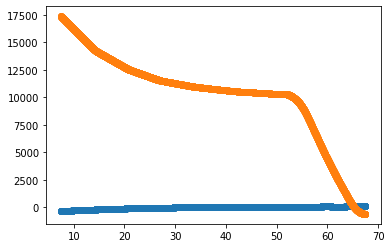

In [12]:
plt.scatter(df["ts"], df["loc.x"])
plt.scatter(df["ts"], df["loc.y"])

(0.0, 1837.5000000000005)

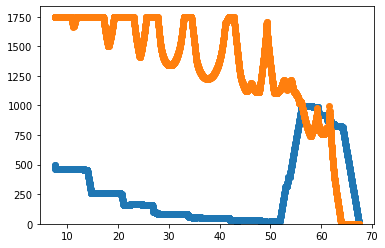

In [13]:
plt.scatter(df["ts"], df["speed"])
plt.scatter(df["ts"], df["o_t_speed"])
plt.ylim(0)

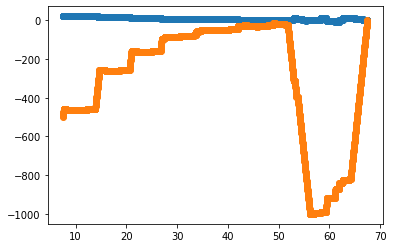

In [14]:
plt.scatter(df["ts"], df["v.x"])
plt.scatter(df["ts"], df["v.y"])

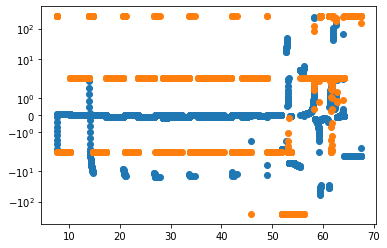

In [15]:
#plt.scatter(df["ts"], (df["v.x"] - df["v.x"].shift(-1)))#/(df["ts"]-df["ts"].shift(-1)))
plt.scatter(df["ts"], (df["v.x"].shift(1) - df["v.x"]) / (df["ts"].shift(1) - df["ts"]))
plt.scatter(df["ts"], (df["v.y"].shift(1) - df["v.y"]) / (df["ts"].shift(1) - df["ts"]))
plt.yscale("symlog")

/tmp/ipykernel_2135738/2971926304.py:7: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)


(-0.05, 0.05)

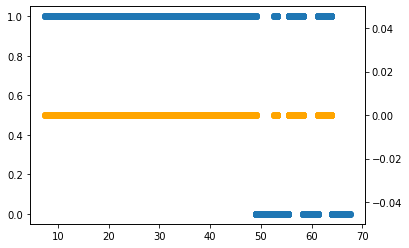

In [16]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df["ts"], 1-df["o.ct"].isna().astype(int))
ax2.scatter(df["ts"], df["ts"] - df["o.ct_ts"], color="orange")

ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)

In [17]:
def plot_collision_info(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (~(sample["o.ct"].isna())).astype(int), label="ct")
    plt.scatter(sample["ts"], sample["o.cs"].fillna(0).astype(int)+0.05, label="cs")
    plt.scatter(sample["ts"], sample["o.cac"].fillna(0).astype(int)+0.1, label="cac")
    plt.scatter(sample["ts"], sample["o.cbdr"].fillna(0).astype(int)+0.15, label="cbdr")
    plt.legend()

ipywidgets.interact(plot_collision_info, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=59.983333…

<function __main__.plot_collision_info(hist_length, max_time)>

In [18]:
df[df["ts"] > 112.0]["o.ct_dv"]

Series([], Name: o.ct_dv, dtype: object)

(0.0, 9629.113737929274)

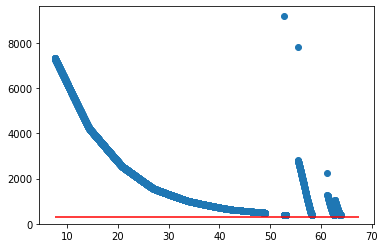

In [19]:
plt.scatter(df["ts"], df["o_ct_dist"])
plt.hlines(300, df["ts"].min(), df["ts"].max(), color="red")
plt.ylim(0)

In [20]:
df.groupby("o.ct")["ts"].describe()

,count,mean,std,min,25%,50%,75%,max
o.ct,,,,,,,,
2a02438e-fa16-43fc-8f04-41f8dd61eebe,76.0,63.029167,1.563302,52.633333,62.962500,63.275,63.587500,63.900000
46fc9a14-bf1d-48ec-826d-99a8385abfcb,172.0,56.875000,0.829938,55.450000,56.162500,56.875,57.587500,58.300000
9b040571-d480-4d1c-a305-b1f24026a3ff,2524.0,28.574168,12.236987,7.500000,18.012500,28.525,39.037500,53.200000
c6289b5b-5bf6-4d2e-acaa-41583c4d078a,86.0,61.975000,0.416166,61.266667,61.620833,61.975,62.329167,62.683333


In [21]:
df.groupby("o.ct")["o_ct_dist"].describe()

,count,mean,std,min,25%,50%,75%,max
o.ct,,,,,,,,
2a02438e-fa16-43fc-8f04-41f8dd61eebe,76.0,889.759256,1294.560200,389.960616,468.929431,648.546157,868.691391,9184.870227
46fc9a14-bf1d-48ec-826d-99a8385abfcb,172.0,1512.770059,759.691006,381.761959,821.731946,1487.755862,2182.761037,2815.599187
9b040571-d480-4d1c-a305-b1f24026a3ff,2524.0,2224.396354,1868.220107,370.125887,760.925043,1427.606486,3257.191390,7359.621568
c6289b5b-5bf6-4d2e-acaa-41583c4d078a,86.0,749.886519,282.865828,378.163305,487.482774,714.252370,988.955337,1279.567133


(64.0, 70.48249999999733)

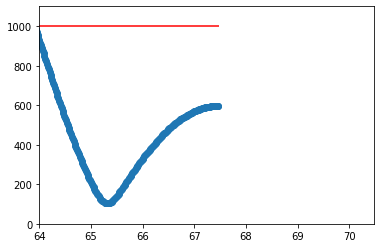

In [30]:
plt.scatter(df["ts"], df["o_t_dist"])
plt.hlines(1000, df["ts"].min(), df["ts"].max(), color="red")
plt.ylim(0,1100)
plt.xlim(64)

In [23]:
df.groupby(["o.t_loc.x", "o.t_loc.y"])["ts"].describe().sort_values(["min"])

,,count,mean,std,min,25%,50%,75%,max
o.t_loc.x,o.t_loc.y,,,,,,,,
0.0,0.0,3599.0,37.483333,17.318102,7.5,22.491667,37.483333,52.475,67.466667


In [24]:
df.groupby(["o.t_loc.x", "o.t_loc.y"])["o_t_dist"].describe()

,,count,mean,std,min,25%,50%,75%,max
o.t_loc.x,o.t_loc.y,,,,,,,,
0.0,0.0,3599.0,10219.685345,3983.880767,103.344312,10210.42111,10761.630435,12257.727994,17362.55378


In [25]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    plt.figure(figsize=(10, 10))
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::20]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["v.x"], sample["v.y"], label="v")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    cmap = plt.get_cmap('viridis')
    for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(df["o.ct"].unique())))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        if len(ct) == 0:
            continue
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    plt.axis('equal')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=59.983333…

<function __main__.plot_collision_chart(hist_length=67.48333333333079, max_time=67.48333333333079)>

In [26]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"], label="ship")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    cmap = plt.get_cmap('viridis')
    for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(sample["o.ct"].unique())))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    #plt.axis('square')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.gca().get_xlim()[1]-plt.gca().get_xlim()[0], plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0]
    plt.legend()
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=59.983333…

<function __main__.plot_collision_chart(hist_length=67.48333333333079, max_time=67.48333333333079)>

In [27]:
df["v.x"].describe()

count    3600.000000
mean        7.197449
std         6.700244
min        -9.668461
25%         1.967261
50%         5.654562
75%        10.666599
max        19.808900
Name: v.x, dtype: float64

In [28]:
df["v.y"].describe()

count    3.600000e+03
mean    -2.991082e+02
std      3.076223e+02
min     -9.991886e+02
25%     -4.619763e+02
50%     -1.631842e+02
75%     -5.230704e+01
max      4.440892e-16
Name: v.y, dtype: float64

# 